#### Libraries

In [1]:
import os
import re

import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from nltk.stem import PorterStemmer

%matplotlib inline

#### Constants

In [2]:
# address to the root dir
ROOT_DIR = os.path.abspath(os.getcwd())

# const for training / cross-validation data split
TRAINING_SET_SIZE = 0.7

# vocabulary size / no. of features
VOCAB_SIZE = 4000

#### Model creation functions

In [3]:
def processMail(mail):
    """
    Parameters
    -------------
    mail: string
        The block of raw text/mail.
        
    Returns
    -------------
    clean_mail: list
        A list of all the stemmed words in the mail.
    
    Task
    -------------
    - Extract the body of the mail, i.e., remove headers.
    - Lower case.
    - Strip HTML.
    - Substitute numbers, urls, email addresses and $ signs 
      by ' number ', ' httpaddr ', ' emailaddr ' and ' dollar ' respectively.
    - Split text based on punctuatios (also removes punctuation).
    - Stem each word and append non-empty stems to clean_mail.

    """
    clean_mail = []
    
    # remove headers
    hdrstart = mail.find(chr(10) + chr(10))
    mail = mail[hdrstart:]

    # lower case
    mail = mail.lower()
    
    # strip all HTML
    mail =re.compile('<[^<>]+>').sub(' ', mail)

    # handle Numbers
    mail = re.compile('[0-9]+').sub(' number ', mail)

    # handle URLS
    mail = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', mail)

    # handle Email Addresses
    mail = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', mail)
    
    # handle $ sign
    mail = re.compile('[$]+').sub(' dollar ', mail)
    
    # get rid of any punctuation
    mail = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', mail)
    
    # clean, stem and then append the word to clean_mail
    stemmer = PorterStemmer()
    for word in mail:
        # remove alpha-numeric characters
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        if len(word):
            word = stemmer.stem(word)
            clean_mail.append(word)
    
    return clean_mail

In [4]:
def createVocabulary(mails, size=1000):
    """
    Parameters
    -------------
    mails: list
        List of mails where each element/mail is a list of stemmed words.
    size: int
        Size of the vocabulary.
        
    Returns
    -------------
    vocab: list
        List of most common words in mails.
    
    Task
    -------------
    Finds the most common words in mails.

    """
    all_words_w_count = {}
    
    # record the amount of times each word has occured
    for mail in mails:
        for word in mail:
            try:
                all_words_w_count[word] += 1
            except:
                all_words_w_count[word] = 1
    
    # sort the words by most frequent to least
    sorted_words = [w for w, c in sorted(all_words_w_count.items(), \
                                         key=lambda item: item[1], reverse=True)]
    
    # returns the complete list if the unique words found in mail < size provided 
    try:
        vocab = sorted_words[:size]
    except:
        vocab = sorted_words
    return vocab

In [5]:
def getFeatureMatrix(mails, vocab):
    """
    Parameters
    -------------
    mails: list
        List of mails where each element/mail is a list of stemmed words.
    vocab: list
        List of most common words in all mails.
        
    Returns
    -------------
    X: numpy array 
        The feature matrix with shape (m, n).
    
    Task
    -------------
    - Initializes the feature matrix X with shape (m, n) 
      where m is the no. of mails and n is the no. of words in vocab.
    - For each mail fills in a row of X where jth col is marked 1 if 
      the jth word in vocab is present in mail and 0 otherwise.

    """
    
    # useful variables
    m = len(mails)
    n = len(vocab)
    
    # initializing X
    X = np.zeros((m, n))
    
    # filling in X
    for i, mail in enumerate(mails):
        for j, word in enumerate(vocab):
            X[i, j] = word in mail
    
    return X

#### Loading data

In [6]:
# Asserts that the data.rar file has already been extracted
assert os.path.exists(os.path.join(ROOT_DIR, 'data')), \
'Please extract the data file from data.rar into the root directory of this project.'

# useful variables
clean_mails = []
labels = []

# pointer to the directory that holds sub-directories of email samples
data_dir = os.path.join(ROOT_DIR, 'data\spamassassin')

# iterate over sub-directories
for sub_dir_name in os.listdir(data_dir):
    is_spam = 'spam' in sub_dir_name
    
    # pointer to sub-directory
    sub_dir = os.path.join(data_dir, sub_dir_name)
    # for each mail in sub-directory
    for mail_id in os.listdir(sub_dir):
        try:
            with open(os.path.join(sub_dir, mail_id)) as f:
                mail_contents = f.read()
                
            # clean mails_contents
            clean_mail = processMail(mail_contents)
            
            # append to clean_mails and labels
            clean_mails.append(clean_mail)
            labels.append(int(is_spam))
            
        except:
            continue


#### Model variables

In [7]:
n = VOCAB_SIZE
m = len(clean_mails)

vocabulary = createVocabulary(clean_mails, VOCAB_SIZE)

X = getFeatureMatrix(clean_mails, vocabulary)
y = np.array(labels)

#### Train / Cross-Validation set split

In [8]:
mval = int(m * (1-TRAINING_SET_SIZE))
rand_indices = np.random.choice(m, mval, replace=False)

Xval, yval = X[rand_indices, :], y[rand_indices]
X, y = np.delete(X, rand_indices, axis=0), np.delete(y, rand_indices)

m = y.size

#### Model training

In [9]:
clf = svm.LinearSVC(dual=(m<n)) # sets dual=True if m < n
clf.fit(X, y)

LinearSVC(dual=False)

#### Model performance

In [10]:
predictions = clf.predict(Xval)

The model has a 97.24 % accuracy.
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1278
           1       0.96      0.94      0.95       534

    accuracy                           0.97      1812
   macro avg       0.97      0.96      0.97      1812
weighted avg       0.97      0.97      0.97      1812

--------------------------------------------------------------
F-Measure: 0.953
--------------------------------------------------------------


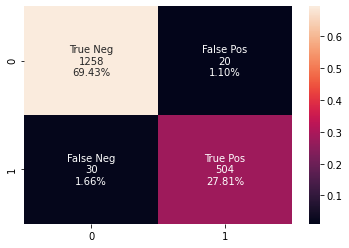

In [11]:
# Accuracy
accuracy = np.average(yval==predictions) * 100
print(f'The model has a {round(accuracy, 2)} % accuracy.')
print('--------------------------------------------------------------')

# Classification Report
print(classification_report(yval, predictions))
print('--------------------------------------------------------------')

# F-1 Score
score_2 = f1_score(yval, predictions, average = 'binary')
print('F-Measure: %.3f' % score_2)
print('--------------------------------------------------------------')

# Confusion Matrix
cf_matrix = confusion_matrix(yval, predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='')

pass

#### Making predictions

In [12]:
def predictSamples(filenames):
    """
    Parameters
    -------------
    filenames: list
        List of filenames of the files to be predicted.
        
    Returns
    -------------
    Nothing to Return. Prints the result.
    
    Task
    -------------
    Predicts whether samples provided as 'filenames' are spam or not.

    """
    # if passed an empty list
    if not filenames:
        print('Nothing to predict.')
        return
    
    # extracting clean mails from files of filenames provided
    clean_mails = []
    for i, filename in enumerate(filenames):
        path_to_file = os.path.join(ROOT_DIR, 'data', 'samples', filename)
        
        try:
            with open(path_to_file) as f:
                mail_contents = f.read()
        except:
            print(f'Could not read {filename}.')
            continue
        
        clean_mail = processMail(mail_contents)
        clean_mails.append(clean_mail)
    
    # create the feature matrix
    try:
        X = getFeatureMatrix(clean_mails, vocabulary)
    except:
        print('No vocabulary has been created.')
        return
    
    # predicting
    try:
        predictions = clf.predict(X)
    except:
        print('No model has been trained.')
        return
    
    # outputting predictions
    for i, pred in enumerate(predictions):
        if pred:
            print(f'{filenames[i]} is spam.')
        else:
            print(f'{filenames[i]} is not spam.') 
    return

In [13]:
# example
filenames = ['emailSample1.txt', 'emailSample2.txt']
predictSamples(filenames)

emailSample1.txt is not spam.
emailSample2.txt is spam.
